In [1]:
from open_clip import create_model
from torchvision import transforms
import torch
import pickle
import os


/home/moto/miniconda3/envs/py39/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [44]:
import numpy as np
import pandas as pd
import pickle
import glob

from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
np.bool = bool

from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
from PIL import Image


In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
from transformers import pipeline
import transformers

checkpoint = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection", use_fast=True)

Device set to use cuda:0


In [42]:
model = create_model("hf-hub:imageomics/bioclip", output_dict=True, require_pretrained=True)
model = model.to(device)

In [74]:
def is_overlap(A, B):
    # A = [xmin,ymin,xmax,ymax]
    # B = [xmin,ymin,xmax,ymax]
    rs = not (A[0] > B[2] or A[2] < B[0] or A[1] > B[3] or A[3] < B[1])
    return rs

def does_contain(pp, A, verbose=False):
    for B in pp:
        if is_overlap(A, B):
            if verbose:
                print("Overlap:", B)
            return True
    return False

In [115]:
IMG_SIZE = 256*3

filename = 'workspace/CS003657.jpg'

def read_image(filename, verbose=False):
    if verbose:
        print(filename)
        
    image = Image.open(filename).convert('RGB')
    wpercent = (IMG_SIZE / float(image.size[0]))
    hsize = int((float(image.size[1]) * float(wpercent)))
    image = image.resize((IMG_SIZE, hsize), Image.Resampling.LANCZOS)

    if verbose:
        print(image.size)
    return image

def get_butterfly_wings(image, predictions, return_wings=True, max_nb_wings=4):
    bboxes = []
    counter = 0
    
    sub_images = []
    for prediction in predictions[:max_nb_wings]:
        box = prediction["box"]
        label = prediction["label"]
        score = prediction["score"]
    
        xmin, ymin, xmax, ymax = box.values()
        bbox = [xmin, ymin, xmax, ymax]
    
        if not does_contain(bboxes, bbox):
            bboxes.append(bbox)
            
            if return_wings:
                cropped = image.crop((xmin, ymin, xmax, ymax))
                sub_images.append(cropped)
            counter += 1

    if return_wings:
        return bboxes, sub_images
    return bboxes

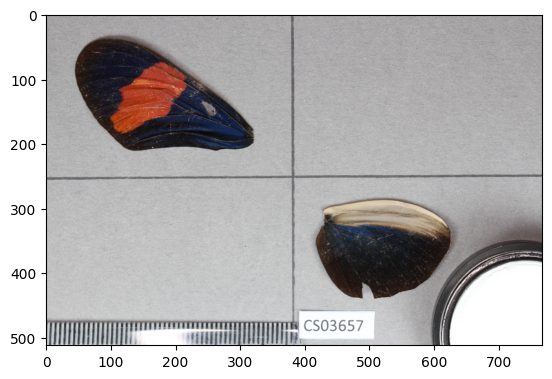

In [116]:
image = read_image(filename)
plt.imshow(image);

In [117]:
predictions = detector(
    image,
    candidate_labels=["butterfly"], # ["butterfly wing"],
)
bboxes, sub_images = get_butterfly_wings(image, predictions)
print(bboxes)

[[42, 35, 325, 214], [417, 285, 625, 442]]


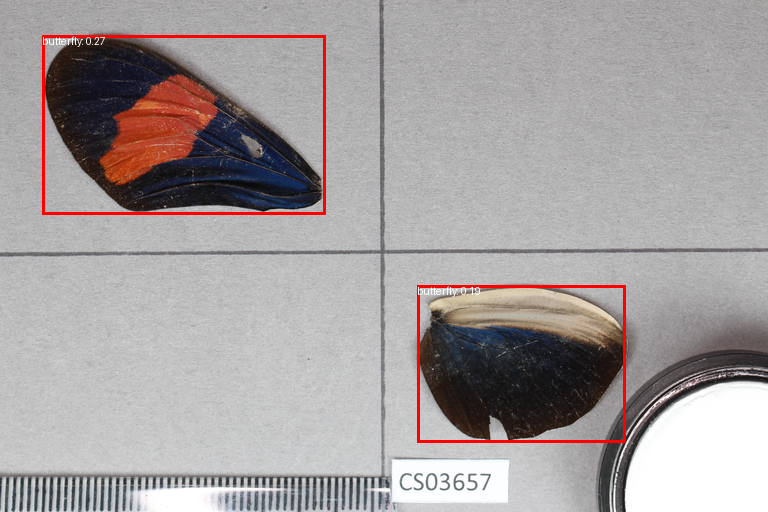

In [118]:
from PIL import ImageDraw

draw_image = image.copy()
draw = ImageDraw.Draw(draw_image)

for prediction in predictions[:4]:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=3)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

draw_image

In [109]:
filenames = glob.glob("sub_images/positive/*.jpg")
print(len(filenames))

7598


In [110]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, filenames, transform=None):
        self.filenames = filenames
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = Image.open(filename).convert('RGB')  # Convert to RGB to ensure consistency

        if self.transform:
            image = self.transform(image)

        return {'filename': filename, 'image': image}

# Define any transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
])

dataset = ImageDataset(filenames[:], transform=transform)

# Access a sample
sample = dataset[0]
print("Filename:", sample['filename'])
print("Image tensor shape:", sample['image'].shape)
len(filenames), len(dataset)

Filename: sub_images/positive/CAM016787_3.jpg
Image tensor shape: torch.Size([3, 224, 224])


(7598, 7598)

In [112]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32*4, shuffle=False)

features_dict = {}
model.eval()
model.to(device)

with torch.no_grad():
    for batch in tqdm(dataloader):
        images = batch['image'].to(device)
        filenames = batch['filename']

        features = model(images)['image_features']
        features = features.detach().cpu().numpy()
        
        # Store features in the dictionary
        for filename, feature in zip(filenames, features):
            features_dict[filename] = feature

len(features_dict)

100%|███████████████████████████████████████████| 60/60 [04:26<00:00,  4.44s/it]


7598

In [120]:
with open('workspace/bioclip_features.pickle', 'wb') as handle:
    pickle.dump(features_dict, handle)

# Play

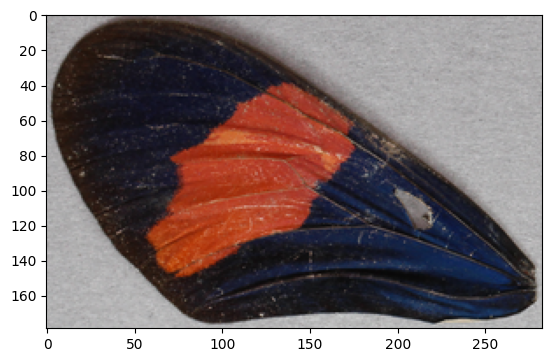

In [125]:
plt.imshow(sub_images[0])

In [138]:
si = [transform(i).to(device) for i in sub_images]
# model(si[0].unsqueeze(0))['image_features']
image_features = model(torch.stack(si))['image_features']
image_features = image_features.detach().cpu().numpy()
image_features.shape
# image_features = self.model(torch.stack(si))['image_features']

(2, 512)